In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(99)


In [26]:
dataFrame = pd.read_csv('/content/drive/My Drive/data/halong_quality.csv', index_col='date')

In [27]:
dataFrame

,pm25,pm10,o3,no2,so2,co
date,,,,,,
3/1/2019,6,6,45,3,500,NaN
3/2/2019,59,55,1,6,500,NaN
3/3/2019,43,28,5,9,500,NaN
3/4/2019,27,3,4,16,500,NaN
3/5/2019,48,17,16,1,500,NaN
...,...,...,...,...,...,...
5/28/2024,64,32,48,9,500,NaN
5/29/2024,47,20,23,8,500,NaN
5/30/2024,40,6,49,9,500,NaN


In [28]:
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0) # Handling missing values, fill with 0 instead of removing
dataFrame = pd.DataFrame(imputer.fit_transform(dataFrame), columns=dataFrame.columns)
dataFrame = dataFrame.reset_index(drop=True)
# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['pm25']] = target_scaler.fit_transform(dataFrame[['pm25']].to_numpy())
df_scaled = df_scaled.astype(float)

In [29]:
# Single step dataset preparation
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df[['pm25']].iloc[i + window].values)
	return np.array(xRes), np.array(yRes)


In [30]:
# Dataset splitting
SPLIT = 0.7
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

In [31]:
n_forecast = 5

In [32]:
model_gru = keras.Sequential()
model_gru.add(keras.layers.GRU(30, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(keras.layers.Dropout(0.2))
model_gru.add(keras.layers.Dense(n_forecast, activation='linear'))
model_gru.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 30)                3420      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 155       
                                                                 
Total params: 3575 (13.96 KB)
Trainable params: 3575 (13.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
history = model_gru.fit(X_train, y_train, epochs=20)

Epoch 1/20
42/42 [==============================] - 4s 22ms/step - loss: 0.0350 - MAE: 0.1445
Epoch 2/20
42/42 [==============================] - 1s 19ms/step - loss: 0.0208 - MAE: 0.1143
Epoch 3/20
42/42 [==============================] - 1s 21ms/step - loss: 0.0192 - MAE: 0.1091
Epoch 4/20
42/42 [==============================] - 1s 16ms/step - loss: 0.0189 - MAE: 0.1071
Epoch 5/20
42/42 [==============================] - 1s 12ms/step - loss: 0.0182 - MAE: 0.1048
Epoch 6/20
42/42 [==============================] - 1s 14ms/step - loss: 0.0182 - MAE: 0.1034
Epoch 7/20
42/42 [==============================] - 1s 14ms/step - loss: 0.0175 - MAE: 0.1016
Epoch 8/20
42/42 [==============================] - 1s 15ms/step - loss: 0.0173 - MAE: 0.1011
Epoch 9/20
42/42 [==============================] - 1s 14ms/step - loss: 0.0175 - MAE: 0.1018
Epoch 10/20
42/42 [==============================] - 1s 15ms/step - loss: 0.0174 - MAE: 0.1011
Epoch 11/20
42/42 [==============================] - 1s 15m

In [34]:
# Reload the data with the date index
dataFrame = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv') # Assuming the CSV file contains a 'Date' column
dataFrame['date'] = pd.to_datetime(dataFrame['date'])
dataFrame.set_index('date', inplace=True)

# Forecast Plot with Dates on X-axis
predicted_values = model_gru.predict(X_test)

d = {
	'Predicted_pm25': predicted_values[:, 0],
 'Actual_pm25': y_test[:, 0],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):] # Assigning the correct date index


18/18 [==============================] - 0s 4ms/step


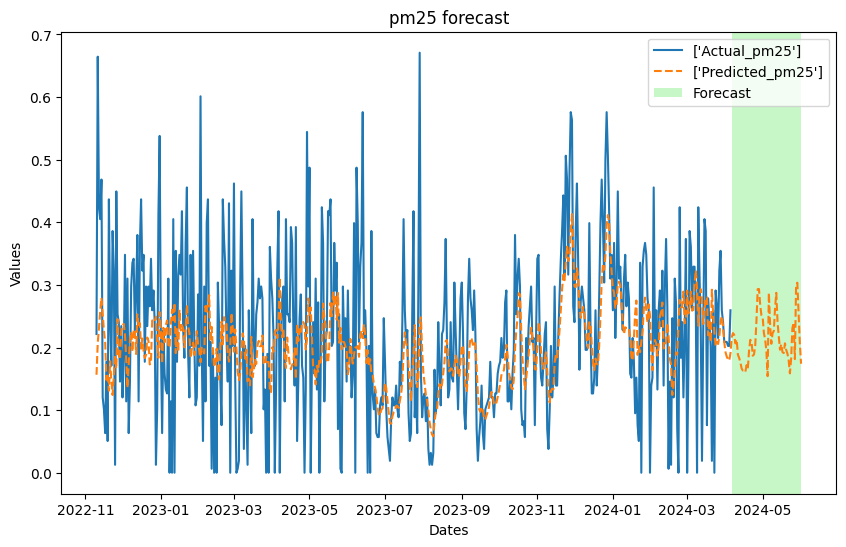

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
# highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1 # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual_pm25']][:highlight_start], label=['Actual_pm25'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_pm25']], label=['Predicted_pm25'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('pm25 forecast')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

In [36]:
predicted_values

array([[0.15646484, 0.16174588, 0.16119915, 0.16383846, 0.16093643],
       [0.20724621, 0.21020368, 0.21286318, 0.21445948, 0.21176118],
       [0.23086458, 0.2373802 , 0.24208091, 0.23956773, 0.23655227],
       ...,
       [0.2575487 , 0.26094282, 0.25785333, 0.25641337, 0.25658518],
       [0.2081631 , 0.21626496, 0.20915921, 0.20996192, 0.2163836 ],
       [0.17410333, 0.17802449, 0.17538421, 0.17699805, 0.17835534]],
      dtype=float32)

In [37]:
predicted_values_90 = predicted_values[:18]

In [38]:
pm25_scaler = target_scaler
# Perform the inverse transformation on the scaled pm25 data
predicted_values_90 = pm25_scaler.inverse_transform(predicted_values_90)

# Check the DataFrame to see the reversed pm25 values
print(predicted_values_90)

[[29.721445 30.555847 30.469465 30.886477 30.427956]
 [37.7449   38.21218  38.63238  38.884598 38.458267]
 [41.476604 42.506073 43.248787 42.8517   42.37526 ]
 [45.883667 46.516644 46.739845 46.970608 45.850163]
 [49.157173 49.91185  49.68191  50.127613 48.87916 ]
 [45.16484  46.23059  45.663815 46.219345 44.92956 ]
 [40.82098  41.660915 41.116646 41.685104 40.960457]
 [37.945732 38.856678 38.550316 38.977722 38.630615]
 [28.449244 29.584679 29.076996 29.565714 29.256342]
 [29.861305 30.898584 30.933825 31.49138  31.315813]
 [25.696283 26.314735 26.549732 26.941933 26.621496]
 [33.146553 34.241776 34.73334  35.019485 34.82922 ]
 [28.173994 29.170536 29.044998 29.677734 28.773836]
 [24.610142 25.54793  25.482563 26.157446 25.142859]
 [29.630278 30.8964   31.080753 31.704578 30.843018]
 [34.27699  35.335163 35.639862 36.262897 35.15286 ]
 [31.2648   31.55551  32.190784 32.16391  31.440252]
 [43.740368 44.827145 45.600956 45.491707 45.139282]]


In [39]:
predicted_values_90 = np.concatenate(predicted_values_90, axis=0)

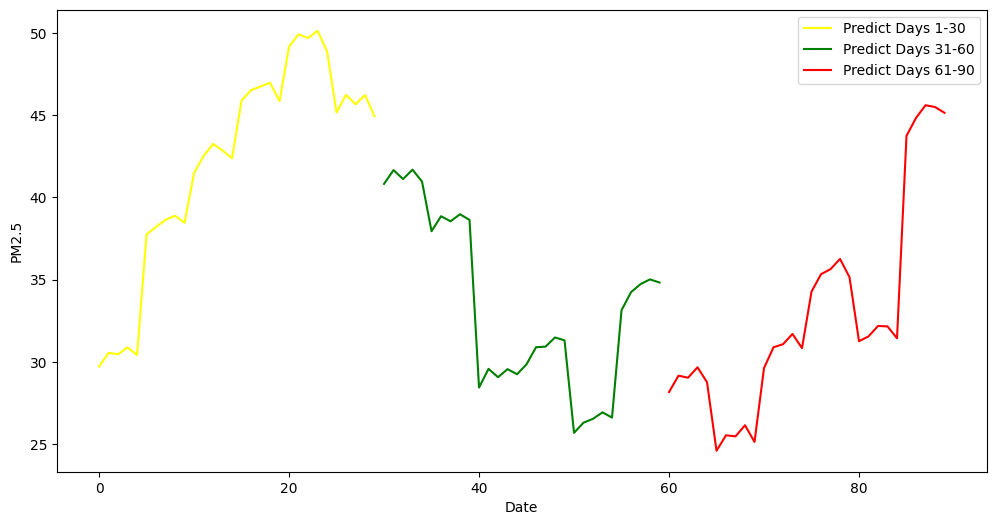

In [40]:
plt.figure(figsize=(12, 6))

dates = np.arange(1, 91)
data = pd.DataFrame({'Date': dates, 'predicted_values_90': predicted_values_90})

plt.plot(data['predicted_values_90'][:30], color='yellow', label='Predict Days 1-30')
plt.plot(data['predicted_values_90'][30:60], color='green', label='Predict Days 31-60')
plt.plot(data['predicted_values_90'][60:], color='red', label='Predict Days 61-90')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()

# Show plot
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
if predicted_values.ndim == 1:
    predicted_values = predicted_values.reshape(-1, 1)

# Inverse transform the predicted values
predicted_values_all = pm25_scaler.inverse_transform(predicted_values)

# Check the shape after inverse transformation
print("Shape of y_test:", y_test.shape)
print("Shape of predicted_values_all:", predicted_values_all.shape)
# Aggregate predictions to match the shape of y_test
predicted_values_aggregated = np.mean(predicted_values_all, axis=1, keepdims=True)

# Calculate the RMSE, MAE, and MAPE
rmse = mean_squared_error(y_test, predicted_values_aggregated, squared=False)
mae = mean_absolute_error(y_test, predicted_values_aggregated)
mape = mean_absolute_percentage_error(y_test, predicted_values_aggregated)

# Print the results
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)


Shape of y_test: (570, 1)
Shape of predicted_values_all: (570, 5)
RMSE: 38.78710097669982
MAE: 37.675006005903256
MAPE: 7758764805007277.0
